In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import LinearLR

from splice import splice_model
from splice.base import *
from splice.loadCellsFile import *
from splice.utilities import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Uberphys

### Data wrangling 

In [2]:
G = mat2pyCellFileCleanup("../data/uberphys/A324_2023_07_21.mat")

No region found for cell 190, entering 'None'
No region found for cell 191, entering 'None'
No region found for cell 192, entering 'None'
No region found for cell 193, entering 'None'
No region found for cell 194, entering 'None'
No region found for cell 195, entering 'None'
No region found for cell 196, entering 'None'
No region found for cell 197, entering 'None'
No region found for cell 198, entering 'None'
No region found for cell 199, entering 'None'
No region found for cell 200, entering 'None'
No region found for cell 201, entering 'None'
No region found for cell 202, entering 'None'
No region found for cell 203, entering 'None'
No region found for cell 547, entering 'None'
No region found for cell 2202, entering 'None'
No region found for cell 2203, entering 'None'
No region found for cell 2204, entering 'None'


In [3]:
region = np.array(G["region"])

ADS_inds_all = np.argwhere(region == 'ADS').flatten()
M2_inds_all = np.argwhere(region == 'M2').flatten()
TS_inds_all = np.argwhere(region == 'TS').flatten()

incl_units = np.argwhere(G["standard_inclusion_criteria"] == 1).flatten()
excl_units =  [135, 981, 1660, 1664, 1952, 2028, 2222, 2230, 2232, 2260, 2261, 2263, 2265, 2266, 2267, 2268, 2460, 2549, 3079]

ADS_inds = np.intersect1d(ADS_inds_all, incl_units)
M2_inds = np.intersect1d(M2_inds_all, incl_units)
TS_inds = np.intersect1d(TS_inds_all, incl_units)

ADS_inds = np.setdiff1d(ADS_inds, excl_units)
M2_inds = np.setdiff1d(M2_inds, excl_units)
TS_inds = np.setdiff1d(TS_inds, excl_units)

In [4]:
ADS_inds_all.shape, ADS_inds.shape, M2_inds_all.shape, M2_inds.shape, TS_inds_all.shape, TS_inds.shape

((394,), (318,), (170,), (149,), (296,), (127,))

In [5]:
# make per region dataframes w/ spike times
ads_df = selectCells(G, ADS_inds)
m2_df = selectCells(G, M2_inds)
ts_df = selectCells(G, TS_inds)

In [6]:
# calculate firing rates for each trial
getSessionRates(ads_df, .05, .1, adaptive=False)
getSessionRates(m2_df, .05, .1, adaptive=False)
getSessionRates(ts_df, .05, .1, adaptive=False)

In [7]:
m2_jagged_bins = []
for i, bins in enumerate(m2_df['binned']):
    m2_jagged_bins.append(bins)

m2_bins = np.hstack(m2_jagged_bins).T


ts_jagged_bins = []
for i, bins in enumerate(ts_df['binned']):
    ts_jagged_bins.append(bins)

ts_bins = np.hstack(ts_jagged_bins).T

ads_jagged_bins = []
for i, bins in enumerate(ads_df['binned']):
    ads_jagged_bins.append(bins)

In [8]:
m2_jagged_rates = []
for i, rates in enumerate(m2_df['rates']):
    m2_jagged_rates.append(rates)

ts_jagged_rates = []
for i, rates in enumerate(ts_df['rates']):
    ts_jagged_rates.append(rates)

ads_jagged_rates = []
for i, rates in enumerate(ads_df['rates']):
    ads_jagged_rates.append(rates)


In [9]:
# convert to numpy array so we can index witt lists
m2_bins = np.zeros(714, dtype="object")
m2_rates = np.zeros(714, dtype="object")
for i in range(len(m2_jagged_bins)):
    m2_bins[i] = m2_jagged_bins[i]
    m2_rates[i] = m2_jagged_rates[i]

ts_bins = np.zeros(714, dtype="object")
ts_rates = np.zeros(714, dtype="object")
for i in range(len(ts_jagged_bins)):
    ts_bins[i] = ts_jagged_bins[i]
    ts_rates[i] = ts_jagged_rates[i]

ads_bins = np.zeros(714, dtype="object")
ads_rates = np.zeros(714, dtype="object")
for i in range(len(ads_jagged_bins)):
    ads_bins[i] = ads_jagged_bins[i]
    ads_rates[i] = ads_jagged_rates[i]

In [10]:
test_inds = np.arange(0, len(m2_bins), 8)
train_inds = [ind for ind in np.arange(0, len(m2_bins)) if (ind not in test_inds)]

m2_train_bins = np.hstack((m2_bins[train_inds])).T  # type: ignore
m2_test_bins = np.hstack((m2_bins[test_inds])).T  # type: ignore

ads_train_bins = np.hstack((ads_bins[train_inds])).T  # type: ignore
ads_test_bins = np.hstack((ads_bins[test_inds])).T  # type: ignore

m2_train_rates = np.hstack((m2_rates[train_inds])).T  # type: ignore
m2_test_rates = np.hstack((m2_rates[test_inds])).T  # type: ignore

ads_train_rates = np.hstack((ads_rates[train_inds])).T  # type: ignore
ads_test_rates = np.hstack((ads_rates[test_inds])).T  # type: ignore

In [11]:
m2_train_bins.shape

(7209, 149)

### PCA

In [11]:
dims = np.array([1,2,3,4,5,7,10,15, 20, 30 , 50, 75, 100])
pca_bins_loss = np.zeros(len(dims))
pca_rates_loss = np.zeros(len(dims))

In [12]:
for i,dim in enumerate(dims):
    pca_bins = PCA(n_components=dim)
    pca_bins.fit(m2_train_bins)
    pca_bins_loss[i] = F.mse_loss(torch.Tensor(pca_bins.inverse_transform(pca_bins.transform(m2_test_bins))), torch.Tensor(m2_test_bins))

    pca_rates = PCA(n_components=dim)
    pca_rates.fit(m2_train_rates)
    pca_rates_loss[i] = F.mse_loss(torch.Tensor(pca_rates.inverse_transform(pca_rates.transform(m2_test_rates))), torch.Tensor(m2_test_rates))

NameError: name 'm2_train_bins' is not defined

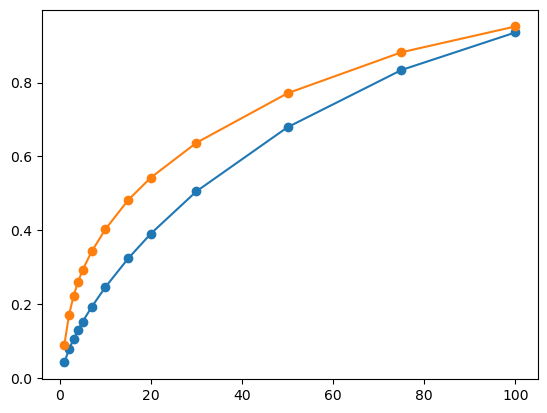

In [ ]:
plt.plot(dims, np.cumsum(pca_bins.explained_variance_ratio_)[np.array(dims)-1], marker='o')
plt.plot(dims, np.cumsum(pca_rates.explained_variance_ratio_)[np.array(dims)-1], marker='o')

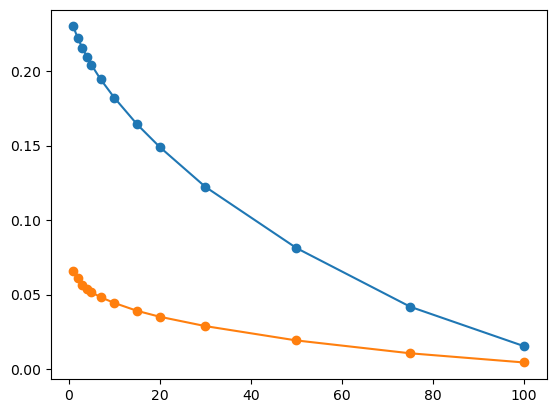

In [ ]:
plt.plot(dims, pca_bins_loss, marker='o')
plt.plot(dims, pca_rates_loss, marker='o')

### Autoencoder

In [20]:
class autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, layers):
        super(autoencoder, self).__init__()
        self.encoder = encoder(input_dim, bottleneck_dim, layers)
        self.decoder = decoder(bottleneck_dim, input_dim, layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
dims = np.array([1,2,3,4,5,7,10,15, 20, 30 , 50])
ae_bins_loss = np.ones(len(dims)) * 100
ae_rates_loss = np.ones(len(dims)) * 100
ae_bins_var_exp = np.zeros(len(dims))
ae_rates_var_exp = np.zeros(len(dims))

lr = 1e-3
epochs = 3000

for i,dim in enumerate(dims):
    print(f"------------ DIM = {dim} -------------")
    ae = autoencoder(m2_train_rates.shape[1], dim, [50]*6)
    ae.train()
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    # scheduler = LinearLR(
    #     optimizer, total_iters=epochs, start_factor=1, end_factor=1/50
    # )

    for epoch in range(epochs):
        print(f"epoch {epoch}", end="\r")
        x_hat = ae(torch.Tensor(m2_train_rates))
        loss = F.mse_loss(x_hat, torch.Tensor(m2_train_rates))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step()

        if epoch % 500 == 0:
            test_loss = F.mse_loss(ae(torch.Tensor(m2_test_rates)), torch.Tensor(m2_test_rates))
            print(f"epoch {epoch}, train loss: {loss.item():.5f}, test loss: {test_loss.item():.5f}")

            if test_loss < ae_bins_loss[i]:
                ae_bins_loss[i] = test_loss.item()

                s1 = torch.var(torch.Tensor(m2_test_bins), dim=0).mean()
                s2 = torch.var(torch.Tensor(m2_test_bins) - ae(torch.Tensor(m2_test_bins)), dim=0).mean()
                ae_bins_var_exp[i] =  1- s2/s1

------------ DIM = 1 -------------
epoch 0, train loss: 0.22586, test loss: 0.21774
epoch 500, train loss: 0.06083, test loss: 0.06152
epoch 1000, train loss: 0.05770, test loss: 0.05798
epoch 1500, train loss: 0.05637, test loss: 0.05695
epoch 2000, train loss: 0.05561, test loss: 0.05709
epoch 2500, train loss: 0.05499, test loss: 0.05729
------------ DIM = 2 -------------
epoch 0, train loss: 0.20661, test loss: 0.20015
epoch 500, train loss: 0.05468, test loss: 0.05504
epoch 1000, train loss: 0.05158, test loss: 0.05402
epoch 1500, train loss: 0.04972, test loss: 0.05451
epoch 2000, train loss: 0.04816, test loss: 0.05467
epoch 2500, train loss: 0.04681, test loss: 0.05533
------------ DIM = 3 -------------
epoch 0, train loss: 0.19496, test loss: 0.18885
epoch 500, train loss: 0.05311, test loss: 0.05381
epoch 1000, train loss: 0.04864, test loss: 0.05241
epoch 1500, train loss: 0.04620, test loss: 0.05318
epoch 2000, train loss: 0.04489, test loss: 0.05437
epoch 2500, train loss:

In [19]:
ae

autoencoder(
  (encoder): encoder(
    (layers): ModuleList(
      (0): Linear(in_features=149, out_features=50, bias=True)
      (1-10): 10 x Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (decoder): decoder(
    (layers): ModuleList(
      (0-9): 10 x Linear(in_features=50, out_features=50, bias=True)
      (10): Linear(in_features=50, out_features=149, bias=True)
    )
  )
)

## MNIST sanity check

### Load data

In [2]:
mnist, mnist_labels = fetch_openml(
        "mnist_784", version=1, return_X_y=True, as_frame=False, parser="auto"
    )

In [3]:
test_inds = np.arange(0, mnist.shape[0], 8)
train_inds = np.array([ind for ind in np.arange(0, mnist.shape[0]) if (ind not in test_inds)])

In [45]:
mnist_train = mnist[train_inds]/255
mnist_test = mnist[test_inds]/255

### PCA

In [46]:
dims = np.array([1,2,3,4,5,7,10,15, 20, 30 , 50])
pca_loss = np.zeros(len(dims))

In [48]:
for i,dim in enumerate(dims):
    pca = PCA(n_components=dim)
    pca.fit(mnist_train)
    pca_loss[i] = F.mse_loss(torch.Tensor(pca.inverse_transform(pca.transform(mnist_test))), torch.Tensor(mnist_test), reduction="mean")

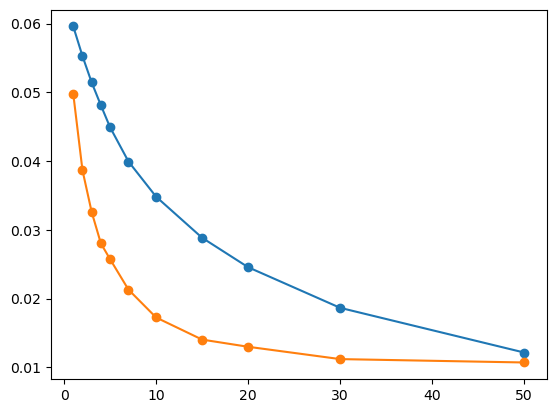

In [49]:
plt.plot(dims, pca_loss, marker='o')
plt.plot(dims, ae_loss, marker='o')

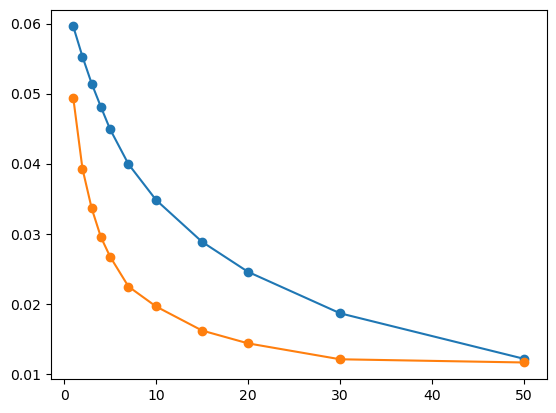

In [30]:
plt.plot(dims, pca_loss, marker='o')
plt.plot(dims, ae_loss, marker='o')

### Autoencoder

In [38]:
class autoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, layers):
        super(autoencoder, self).__init__()
        self.encoder = encoder(input_dim, bottleneck_dim, layers)
        self.decoder = decoder(bottleneck_dim, input_dim, layers[::-1])

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [41]:
mnist_train = torch.Tensor(mnist[train_inds]/255).to(device)
mnist_test = torch.Tensor(mnist[test_inds]/255).to(device)

In [42]:
dims = np.array([1,2,3,4,5,7,10,15, 20, 30 , 50])
ae_loss = np.ones(len(dims)) * 100

lr = 1e-3
batch_size = 128
epochs = 50

for j,dim in enumerate(dims):
    print(f"------------ DIM = {dim} -------------")
    ae = autoencoder(mnist_test.shape[1], dim, [256,128, 64, 32]).to(device)
    ae.train()
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    # scheduler = LinearLR(
    #     optimizer, total_iters=epochs, start_factor=1, end_factor=1/50
    # )

    for epoch in range(epochs):
        for i in range(int(len(mnist_train)/batch_size)):
            print(i, end="\r")
            x = mnist_train[i*batch_size:(i+1)*batch_size]
            y = ae(x)
            loss = torch.nn.functional.mse_loss(y, x, reduction="mean")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        test_loss = F.mse_loss(ae(torch.Tensor(mnist_test)), torch.Tensor(mnist_test), reduction="mean")
        print(f"epoch {epoch}, train loss: {loss.item():.5f}, test loss: {test_loss.item():.5f}")

        if test_loss < ae_loss[j]:
            ae_loss[j] = test_loss.item()

------------ DIM = 1 -------------
epoch 0, train loss: 0.05117, test loss: 0.05935
epoch 1, train loss: 0.04909, test loss: 0.05666
epoch 2, train loss: 0.04988, test loss: 0.05746
epoch 3, train loss: 0.04783, test loss: 0.05605
epoch 4, train loss: 0.04806, test loss: 0.05456
epoch 5, train loss: 0.04941, test loss: 0.05601
epoch 6, train loss: 0.04871, test loss: 0.05718
epoch 7, train loss: 0.04896, test loss: 0.05515
epoch 8, train loss: 0.04791, test loss: 0.05480
epoch 9, train loss: 0.04925, test loss: 0.05391
epoch 10, train loss: 0.04831, test loss: 0.05628
epoch 11, train loss: 0.04792, test loss: 0.05439
epoch 12, train loss: 0.04803, test loss: 0.05462
epoch 13, train loss: 0.04740, test loss: 0.05395
epoch 14, train loss: 0.04683, test loss: 0.05223
epoch 15, train loss: 0.04727, test loss: 0.05336
epoch 16, train loss: 0.04761, test loss: 0.05270
epoch 17, train loss: 0.04785, test loss: 0.05170
epoch 18, train loss: 0.04820, test loss: 0.05259
epoch 19, train loss: 0.0

## Uberphys from npz

In [3]:
npz = np.load("../data/uberphys/A324_2023-07-21.npz")

In [8]:
rates = npz["trialRates"]

In [11]:
export_rates = np.zeros((139 * 714, 2565))
for neuron in range(2565):
    for trial in range(714):
        for time in range(139):
            export_rates[trial*139 + time, neuron] = rates[trial, neuron, time]

In [16]:
rates_no_nan = export_rates[np.argwhere(~np.isnan(export_rates[:,0])).flatten()]

In [20]:
x_train = np.vstack((rates_no_nan[:20000], rates_no_nan[25000:]))
x_test = rates_no_nan[20000:25000]